# 1. Kalman Filters
This notebook compares a linear Kalman filter against an Extended Kalman filter

In [1]:
import numpy as np
from datetime import datetime, timedelta
from ecssupplement import generate_linearish_path, linear_measurement, bearing_range_measurement, linear_kalman_filter, extended_kalman_filter, gaussian_entropy, kl_divergence
from stonesoup.plotter import Plotterly

# Fix our seed
np.random.seed(1991)

In [2]:
truth_path_0, transition_model_0, start_time_0 = generate_linearish_path(0, 0)
truth_path_1, transition_model_1, start_time_1 = generate_linearish_path(0.05, 0.05)
truth_path_2, transition_model_2, start_time_2 = generate_linearish_path(1, 1)

### Linear sensor
Let's first create some measurements with a "linear" sensor

In [3]:
measured_path_0, measurement_model_0 = linear_measurement(truth_path_0)
measured_path_1, measurement_model_1 = linear_measurement(truth_path_1)
measured_path_2, measurement_model_2 = linear_measurement(truth_path_2)

### Non-linear sensor
Then let's measure the same path with a "non-linear" sensor path

In [4]:
bearing_path_0, bearing_model_0 = bearing_range_measurement(truth_path_0)
bearing_path_1, bearing_model_1 = bearing_range_measurement(truth_path_1)
bearing_path_2, bearing_model_2 = bearing_range_measurement(truth_path_2)

Now let us apply KF and EKF to both measurement models

In [5]:
track_lin_0 = linear_kalman_filter(transition_model_0, measurement_model_0, measured_path_0, start_time_0)
track_lin_1 = linear_kalman_filter(transition_model_1, measurement_model_1, measured_path_1, start_time_1)
track_lin_2 = linear_kalman_filter(transition_model_2, measurement_model_2, measured_path_2, start_time_2)

track_ekf_0 = extended_kalman_filter(transition_model_0, bearing_model_0, bearing_path_0, start_time_0)
track_ekf_1 = extended_kalman_filter(transition_model_1, bearing_model_1, bearing_path_1, start_time_1)
track_ekf_2 = extended_kalman_filter(transition_model_2, bearing_model_2, bearing_path_2, start_time_2)

track_ekf_lin_1 = extended_kalman_filter(transition_model_1, measurement_model_1, measured_path_1, start_time_1)

In [6]:
# Plot the results
plotter_0 = Plotterly()
plotter_1 = Plotterly()
plotter_2 = Plotterly()

# Plot ground truths
plotter_0.plot_ground_truths(truth_path_0, [0, 2])
plotter_1.plot_ground_truths(truth_path_1, [0, 2])
plotter_2.plot_ground_truths(truth_path_2, [0, 2])

# Plot measured
plotter_0.plot_measurements(measured_path_0, [0, 2], measurements_label="Linear Sensor")
#plotter_1.plot_measurements(measured_path_1, [0, 2], measurements_label="Linear Sensor")
plotter_2.plot_measurements(measured_path_2, [0, 2], measurements_label="Linear Sensor")

plotter_0.plot_measurements(bearing_path_0, [0, 2], measurements_label="Bearing Sensor")
plotter_1.plot_measurements(bearing_path_1, [0, 2], measurements_label="Bearing Sensor")
plotter_2.plot_measurements(bearing_path_2, [0, 2], measurements_label="Bearing Sensor")

# Plot tracking
plotter_0.plot_tracks(track_lin_0, [0, 2], uncertainty=True, track_label="KF Track")
#plotter_1.plot_tracks(track_lin_1, [0, 2], uncertainty=True, track_label="KF Track")
plotter_2.plot_tracks(track_lin_2, [0, 2], uncertainty=True, track_label="KF Track")

# Plot non-linear tracking
#plotter_0.plot_tracks(track_ekf_0, [0, 2], uncertainty=True)
plotter_0.plot_tracks(track_ekf_0, [0, 2], uncertainty=True, track_label="EKF Track")
plotter_1.plot_tracks(track_ekf_1, [0, 2], uncertainty=True, track_label="EKF Track")
plotter_2.plot_tracks(track_ekf_2, [0, 2], uncertainty=True, track_label="EKF Track")

In [7]:
plotter_1.fig

The advantages of the Extended Kalman Filter are:
- Can work with moderately non-linear sensors or non-linear paths
- Higher accuracy

# 2. Information Measure Development
We will be using Shannon's entropy and related equations in this section

In [8]:
from scipy.stats import multivariate_normal
from matplotlib import pyplot as plt

Generate a path

In [9]:
q = 0.1
true_path, transition_model, start_time =  generate_linearish_path(q, q)

Create 3 sensors

In [10]:
measured_0, measure_model_0 = linear_measurement(true_path, w=5)
measured_1, measure_model_1 = linear_measurement(true_path, w=10)
measured_2, measure_model_2 = linear_measurement(true_path, w=1)

Now do the Kalman Filters

In [11]:
track_0 = linear_kalman_filter(transition_model, measure_model_0, measured_0, start_time)
track_1 = linear_kalman_filter(transition_model, measure_model_1, measured_1, start_time)
track_2 = linear_kalman_filter(transition_model, measure_model_2, measured_2, start_time)

Calculate Shannon entropies

In [12]:
entropy_0 = [gaussian_entropy(state) for state in track_0.states]
entropy_1 = [gaussian_entropy(state) for state in track_1.states]
entropy_2 = [gaussian_entropy(state) for state in track_2.states]

In [13]:
N = len(measured_0)

kl_01 = []
for i in range(N):
    tmp = kl_divergence(measured_0[i], measured_1[i])
    kl_01.append(tmp)

kl_02 = []
for i in range(N):
    tmp = kl_divergence(measured_0[i], measured_2[i])
    kl_02.append(tmp)

kl_12 = []
for i in range(N):
    tmp = kl_divergence(measured_1[i], measured_2[i])
    kl_12.append(tmp)


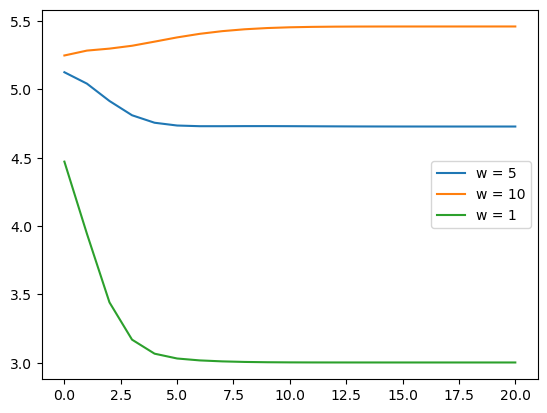

In [14]:
plt.plot(entropy_0, label="w = 5")
plt.plot(entropy_1, label="w = 10")
plt.plot(entropy_2, label="w = 1")
plt.legend()
plt.show()

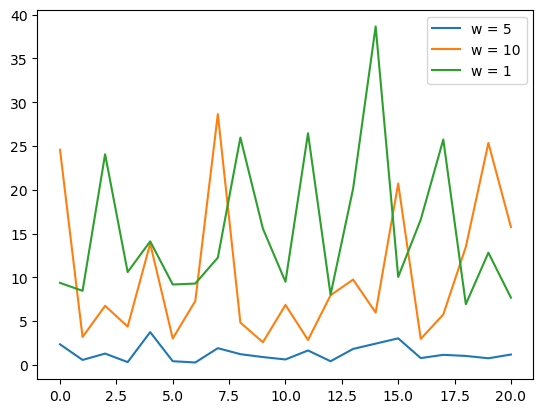

In [18]:
plt.plot(kl_01, label="w = 5")
plt.plot(kl_02, label="w = 10")
plt.plot(kl_12, label="w = 1")
plt.legend()
plt.show()

In [16]:
# Get all the state vectors
#mean = [track_ekf_1.states[-1].state_vector[0], track_ekf_1.states[-1].state_vector[2]]
mean = track_ekf_1.states[0].state_vector.flatten()
covar = track_ekf_1.states[0].covar

#print(mean)
#print(covar)
#print(track_ekf_1.states[-1])
#print(type(covar))
#print(truth_path_1.states[-1].state_vector)
sample = multivariate_normal(mean, covar)
#print(sample[:,[0, 2]])
#print(sample.entropy())
#print(entropy(sample[:,[0, 2]]))
#print(truth_path_1.states[0])
print(len(measured_path_1[0].state_vector))

2


4.850618853145595
0.0


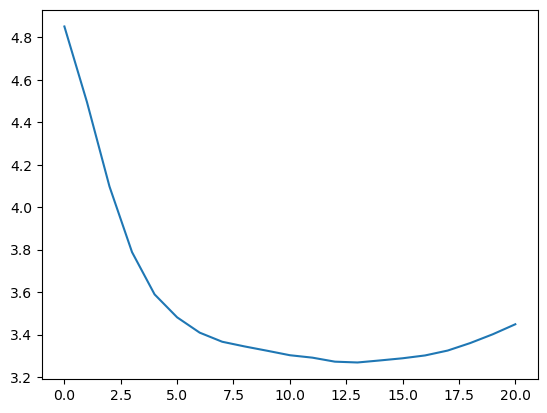

In [17]:
print(gaussian_entropy(track_ekf_1.states[0]))
print(kl_divergence(measured_path_1[0], measured_path_1[0]))
entropies = [gaussian_entropy(state) for state in track_ekf_1.states]
plt.plot(entropies)
plt.show()

